In [1]:
import seaborn as sns
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
import pickle

#from model import *
#from model2 import *
from station_plus_hour_weather_model import *
from inference import *
from criticism import *

In [35]:
with open('data/demand_and_weather.pickle', 'rb') as f:
    data_weather = pickle.load(f)

In [36]:
# data_weather[data_weather.columns[14:]].isnull().sum(axis = 0)

In [37]:
data_weather = data_weather[data_weather.mean_temperature_f.notnull()].reset_index(drop = True)

In [38]:
data  = data_weather

In [39]:
# Get station id dummies:
station_onehot = pd.get_dummies(
    data['start_station_id']).add_prefix('station_')

# Get hour dummies
hour_onehot = pd.get_dummies(data['hour']).add_prefix('hour_')

# Get mean temperature 
mean_temp = data[['mean_temperature_f']]
mean_temp_squared = data[['mean_temperature_f']]**2
constant_ones = np.ones(len(data['mean_temperature_f']))
constant_ones = pd.DataFrame(data=constant_ones)

# # Feature df
# feature_df = pd.concat([station_onehot, hour_onehot, mean_temp,mean_temp_squared,constant_ones], axis=1)

In [40]:
feature_df = pd.concat([station_onehot, hour_onehot, mean_temp,mean_temp_squared,constant_ones], axis=1).shape

In [6]:
torch.tensor(data_weather.mean_temperature_f.values).mean()


tensor(61.0969, dtype=torch.float64)

In [41]:
a,b = feature_generation(data_weather)

In [49]:
a['data'].max()

tensor(7056.)

In [18]:
a['data'].shape

torch.Size([1208874, 97])

In [7]:
dem = data_weather['demand']
mean_temp = data_weather['mean_temperature_f']

In [28]:
data_weather['temp_cat'] = pd.cut(data_weather['mean_temperature_f'], bins = [30,40,50,60,70,80,90,100] )

In [29]:
data_weather['temp_cat']

0          (60, 70]
1          (60, 70]
2          (60, 70]
3          (60, 70]
4          (60, 70]
             ...   
1208869    (70, 80]
1208870    (70, 80]
1208871    (70, 80]
1208872    (70, 80]
1208873    (70, 80]
Name: temp_cat, Length: 1208874, dtype: category
Categories (9, interval[int64]): [(20, 30] < (30, 40] < (40, 50] < (50, 60] ... (70, 80] < (80, 90] < (90, 100] < (100, 110]]

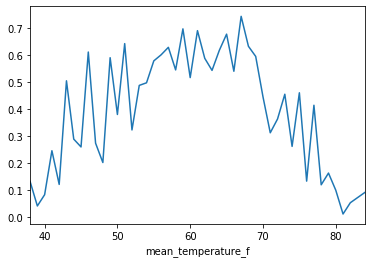

In [46]:
data_weather.groupby('mean_temperature_f')['demand'].mean().plot()

### Plot demand rates for every minute (for a single bike station?) vs mean temperature 
#### At very low or high temperatures the demand is understandably lower

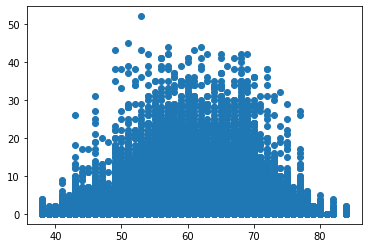

In [8]:
plt.scatter(mean_temp[0:1000000],dem[0:1000000])
plt.show()

### Plotting a distribution over the temperature data 
#### Clearly lower and higher temperatures are less common so there is an imbalance in data points for these temperatures
#### This means there can be bias if we simply use mean temperature in predicting demand 

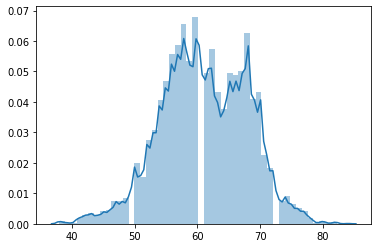

In [9]:
mean_temp = [t for t in mean_temp if str(t)!='nan']
sns.distplot(mean_temp)

#### Let us investigate if presence of rain affects the demand adversely. Plotting distribution density (in blue) of demand for minutes with precipitation and distribution density (in orange) when there is no precipitation

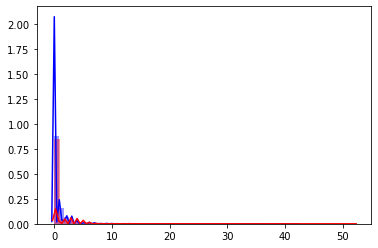

In [69]:
mask_rain = data_weather['precipitation_inches']!='0'
rainy_days = data_weather.loc[mask_rain]
rainy_demand = np.array(rainy_days['demand'])
sns.distplot(rainy_demand,color='blue')

mask_dry = data_weather['precipitation_inches']=='0'
dry_days = data_weather.loc[mask_dry]

dry_demand = np.array(dry_days['demand'])
sns.distplot(dry_demand,color='red')

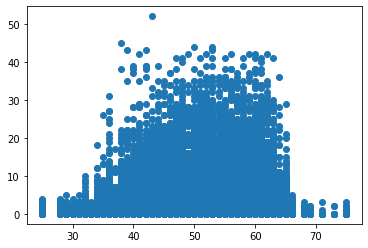

In [67]:
dem = data_weather['demand']
min_temp = data_weather['min_temperature_f']

plt.scatter(min_temp[0:1000000],dem[0:1000000])
plt.show()

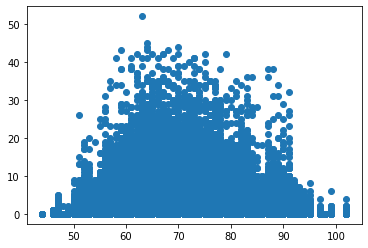

In [68]:
dem = data_weather['demand']
max_temp = data_weather['max_temperature_f']

plt.scatter(max_temp[0:1000000],dem[0:1000000])
plt.show()

In [1]:
prec= data_weather['precipitation_inches']
demand = data_weather['demand']
mean_t = data_weather['mean_temperature_f']

# sns.heatmap()

NameError: name 'data_weather' is not defined

In [68]:
import pickle
with open('data/demand_and_weather.pickle', 'rb') as f:
    data1 = pickle.load(f)

data2 = data1[['demand','start_station_id','hour','mean_temperature_f','precipitation_inches']]
samp = data2.groupby(['start_station_id','hour']).apply(lambda x: x.sample(10)).reset_index(drop = True)
with open('data/demand_weather_sample.pickle','wb') as f:
    pickle.dump(samp, f)

In [59]:
station_onehot = pd.get_dummies(
    samp['start_station_id']).add_prefix('station_')

hour_onehot = pd.get_dummies(samp['hour']).add_prefix('hour_')

feature_df = pd.concat([station_onehot, hour_onehot,], axis=1)



In [90]:
def feature_generation(data):

    # Get station id dummies:
    station_onehot = pd.get_dummies(
        data['start_station_id']).add_prefix('station_')

    # Get hour dummies
    hour_onehot = pd.get_dummies(data['hour']).add_prefix('hour_')
    
    # Get mean temperature 
    mean_temp = data['mean_temperature_f']

    # Feature df
    feature_df = pd.concat([station_onehot, hour_onehot, mean_temp], axis=1)

    data = {
        'demand': torch.tensor(
            data['demand'].values,
            dtype=torch.float),
        'data': torch.tensor(
            feature_df.values,
            dtype=torch.float)}

    feature_info = {'station': {'names': station_onehot.columns.values,
                                'index': np.array([
                                    feature_df.columns.get_loc(c)
                                    for c in station_onehot.columns])},
                    'hour': {'names': hour_onehot.columns.values,
                             'index': np.array([
                                 feature_df.columns.get_loc(c)
                                 for c in hour_onehot.columns])},
                   'mean_temperature_f':{'names': 'mean_temp',
                                         'index': np.array(['94'])}
                       }

    return data, feature_info

In [91]:
data, features = feature_generation(samp)



In [92]:
features

{'station': {'names': array(['station_2', 'station_3', 'station_4', 'station_5', 'station_6',
         'station_7', 'station_8', 'station_9', 'station_10', 'station_11',
         'station_12', 'station_13', 'station_14', 'station_16',
         'station_21', 'station_22', 'station_23', 'station_24',
         'station_25', 'station_26', 'station_27', 'station_28',
         'station_29', 'station_30', 'station_31', 'station_32',
         'station_33', 'station_34', 'station_35', 'station_36',
         'station_37', 'station_38', 'station_39', 'station_41',
         'station_42', 'station_45', 'station_46', 'station_47',
         'station_48', 'station_49', 'station_50', 'station_51',
         'station_54', 'station_55', 'station_56', 'station_57',
         'station_58', 'station_59', 'station_60', 'station_61',
         'station_62', 'station_63', 'station_64', 'station_65',
         'station_66', 'station_67', 'station_68', 'station_69',
         'station_70', 'station_71', 'station_72',